In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Chosing SASSIE CTD data as initial data for the simulation

In [2]:
#-----------------------------------------------------------------------------------|
## SASSIE final data collected files directory -------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'
## Data files directory ------------------------------------------------------------|
ALTO_ALAMO      = 'ALTO_ALAMO/'#----------------------------------------------------|
JetSSP          = 'JetSSP/'#--------------------------------------------------------|
Shipboard_TSG   = 'Shipboard_TSG/'#-------------------------------------------------|
UpTempO         = 'UpTempO/'#-------------------------------------------------------|
uCTD            = 'uCTD/'#----------------------------------------------------------|
CastAway_CTD    = 'CastAway_CTD/'#--------------------------------------------------|
SWIFT           = 'SWIFT/'#---------------------------------------------------------|
Under_Ice_Float = 'Under_Ice_Float/'#-----------------------------------------------|
Wavegliders     = 'Wavegliders/'#---------------------------------------------------|
#-----------------------------------------------------------------------------------|
Saving_Folder = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_Coloc/UpDate_colocs/'

In [3]:
## Cast away CTD data list
CastAway_CTD_content = os.listdir(Final_SASSIE+CastAway_CTD)
CastAway_CTD_content

['SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc']

In [4]:
CTD_cast = xr.open_dataset(Final_SASSIE+CastAway_CTD+CastAway_CTD_content[0])
CTD_cast

<xarray.Dataset>
Dimensions:      (time: 250, depth: 311)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022...
  * depth        (depth) float64 1.0 1.296 1.591 1.887 ... 92.06 92.35 92.65
    longitude    (time) float64 ...
    latitude     (time) float64 ...
Data variables:
    pressure     (depth, time) float64 ...
    temperature  (depth, time) float64 ...
    salinity     (depth, time) float64 ...
    density      (depth, time) float64 ...
Attributes: (12/54)
    DOI:                           10.5067/SASSIE-RVCTD2
    title:                         SASSIE Arctic Field Campaign Castaway Data...
    summary:                       Castaway data collected from R/V Woldstad ...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    conventions:                   CF-1.8, ACDD-1.4
    ...                            ...
    geospatial_lon_max:            -145.3295382
    geospatial_lon_units:          degrees_east
    time_coverage_start:           2022-09-09T15:23:00Z
    time_coverage_end:             2022-09-19T00:27:00Z
    uuid:                          ac6f60ba-010d-472a-8fab-57b0f8483d87
    time_coverage_duration:        P09DT09H04M00S

In [5]:
time = CTD_cast.time
time

<xarray.DataArray 'time' (time: 250)>
array(['2022-09-09T15:22:59.999998208', '2022-09-09T16:32:59.999999232',
       '2022-09-09T17:32:59.999995904', ..., '2022-09-18T23:37:00.000001792',
       '2022-09-18T23:57:00.000000768', '2022-09-19T00:27:00.000004096'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022-0...
    longitude  (time) float64 ...
    latitude   (time) float64 ...
Attributes:
    axis:                   T
    standard_name:          time
    long_name:              time
    coverage_content_type:  coordinate

In [6]:
dt = 3600
Ans = 5
#wishdt = 3600*24*365*Ans
wishdt = 2635000*12*Ans
nstePs = wishdt/dt
nstePs

43916.666666666664

In [7]:
print(2635000*12-3600*24*(365+.25))

62400.0


In [8]:
# in situ temperature [˚C]
temp = CTD_cast.temperature
# in situ pratical salinity [PSU]
sal = CTD_cast.salinity
# longitude & latitude 
lon = CTD_cast.longitude
lat = CTD_cast.latitude
# depth/pressure
pres = CTD_cast.pressure

In [9]:
# conversion of pratical salinity to absolute salinity [SA,g/kg]
SA = gsw.SA_from_SP(sal,pres,lon,lat)
# conversion of temp to potential temperature [˚C]
potemp = gsw.pt_from_t(SA,temp,pres,p_ref = 0)

Text(0.5, 1.0, 'potemp [˚C]')

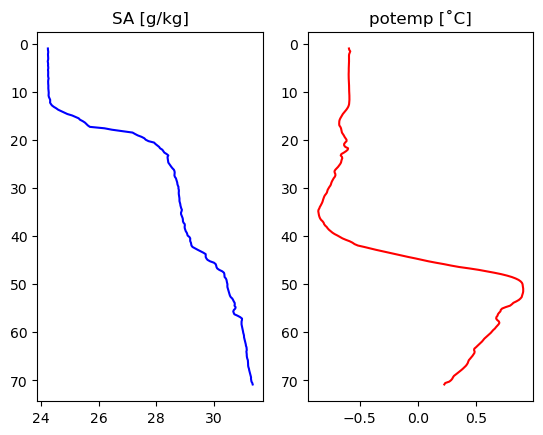

In [11]:
ji = 200
plt.figure()
ax = plt.subplot(121)
ax.plot(SA[:,ji],pres[:,ji],'-b')
ax.invert_yaxis()
plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(potemp[:,ji],pres[:,ji],'-r')
ax.invert_yaxis()
plt.title('potemp [˚C]')

In [12]:
time[ji]

<xarray.DataArray 'time' ()>
array('2022-09-17T23:26:00.000000768', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2022-09-17T23:26:00.000000768
    longitude  float64 ...
    latitude   float64 ...
Attributes:
    axis:                   T
    standard_name:          time
    long_name:              time
    coverage_content_type:  coordinate

In [13]:
print(np.array(lon[ji]),np.array(lat[ji]))

-145.98384665 73.18047164999999


In [14]:
z_ctd = np.array(pres[:,ji]).round(1)
inonan = np.where(~np.isnan(z_ctd))[0]
z_ctd = z_ctd[inonan]
z_ctd.size

236

In [ ]:
#np.diff(z_ctd)

In [ ]:
delZ   = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,10.03, 10.11,
           10.32, 10.80, 11.76, 13.42, 16.04 , 19.82, 24.85,31.10, 38.42, 46.50,
           55.00, 63.50, 71.58]) #,

In [ ]:
delZ.size

In [15]:
delZ2   = np.ones(235)*1
np.cumsum(delZ2).size

235

In [16]:
# MITgcn 1D config depth levels: 23 into 235 levels
z_mitgcm = np.cumsum(delZ2)
z_mitgcm

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [17]:
## Input data
### tRef:
tRef = potemp[inonan,ji]
### sRef:
sRef = sal[inonan,ji]

In [ ]:
#tRef

In [18]:
tRef2 = tRef[0:-1]
sRef2 = sRef[0:-1]

In [19]:
tRef2.size

235

In [20]:
TREF = np.ones(z_mitgcm.size)
SREF = np.ones(z_mitgcm.size)
for i in np.arange(z_mitgcm.size):
    idepth = (np.absolute(z_ctd - z_mitgcm[i])).argmin()
    TREF[i] = tRef[idepth]
    SREF[i] = sRef[idepth]

In [ ]:
plt.figure()
ax = plt.subplot(121)
ax.plot(SREF,z_mitgcm,'-b')
#plt.ylim(0,100)
ax.invert_yaxis()

plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(TREF,z_mitgcm,'-r')
#plt.ylim(0,100)
ax.invert_yaxis()
plt.title('poTemp [˚C]')


In [21]:
TREF.size

235

In [22]:
zato = " ".join(str(np.array(tRef2[i]))+str(',') for i in np.arange(TREF.size)).split()
np.array(zato).reshape(1,235)

array([['-0.5918577847971848,', '-0.5890288637801298,',
        '-0.5806230808946098,', '-0.5855050440003359,',
        '-0.5902246872612447,', '-0.5916350624905795,',
        '-0.5913166343135708,', '-0.5910912995557244,',
        '-0.5910373567999643,', '-0.5912851893293992,',
        '-0.5919226408163862,', '-0.5922134253318638,',
        '-0.5929581828014843,', '-0.5935203241545692,',
        '-0.5935371786496866,', '-0.59346783538786,',
        '-0.5935528684095089,', '-0.5943009388136057,',
        '-0.5944548256154284,', '-0.5944842915448345,',
        '-0.5942816365808337,', '-0.5938726692423937,',
        '-0.593174581679766,', '-0.5923508483434897,',
        '-0.5920358697252774,', '-0.5915882498954572,',
        '-0.5909899071813303,', '-0.5909776706464026,',
        '-0.5909377348950873,', '-0.5905574790526432,',
        '-0.5900189389087593,', '-0.5891047824018608,',
        '-0.5885414835890503,', '-0.5881659094008002,',
        '-0.5879466815574491,', '-0.587750791853080

In [23]:
sal_init = " ".join(str(np.array(sRef2[i]))+str(',') for i in np.arange(sRef2.size)).split()
np.array(sal_init).reshape(1,sRef2.size)

array([['24.113590813519885,', '24.115843852840616,',
        '24.123772016010985,', '24.12364531400899,',
        '24.116714197894883,', '24.119642098299533,',
        '24.119206302282468,', '24.12478345864921,',
        '24.120440126766184,', '24.107861737341818,',
        '24.11724381727296,', '24.121799661057086,',
        '24.118165674703604,', '24.125675085952164,',
        '24.126391159995958,', '24.117186543267472,',
        '24.123044397693093,', '24.124320434123025,',
        '24.121568620430374,', '24.12138203879219,',
        '24.12545486567035,', '24.1377247043637,', '24.12751503530081,',
        '24.122156327361868,', '24.122877541869833,',
        '24.125133816898643,', '24.129957755927943,',
        '24.128559871748436,', '24.129022620296404,',
        '24.13466167228077,', '24.140476619059974,',
        '24.143027407124684,', '24.139241352039935,',
        '24.137649734967095,', '24.14816260065307,',
        '24.171513875123665,', '24.192369334053627,',
        '24.192

In [ ]:
#np.array(sal_init).reshape(1,235)

In [24]:
save_data = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/1D_ocean_ice_column/run/ForcingDataSetting/"

In [25]:
df = pd.DataFrame(np.array(zato).reshape(1,235))
df

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
0,"-0.5918577847971848,","-0.5890288637801298,","-0.5806230808946098,","-0.5855050440003359,","-0.5902246872612447,","-0.5916350624905795,","-0.5913166343135708,","-0.5910912995557244,","-0.5910373567999643,","-0.5912851893293992,",...,"0.3724604310928119,","0.35647815585637893,","0.34172724565874113,","0.3263202862695987,","0.3102295534261778,","0.3016469238478413,","0.2955823600031344,","0.28529852090654856,","0.2698288538933217,","0.23496901716136695,"


In [26]:
df.to_csv(save_data+'TempRef.csv', index=False, header=False)

In [27]:
df = pd.DataFrame(np.array(sal_init).reshape(1,sRef2.size))
df

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
0,"24.113590813519885,","24.115843852840616,","24.123772016010985,","24.12364531400899,","24.116714197894883,","24.119642098299533,","24.119206302282468,","24.12478345864921,","24.120440126766184,","24.107861737341818,",...,"31.088167394876606,","31.10161149094038,","31.112863758260367,","31.125056541223298,","31.145608670400247,","31.1526816634206,","31.15033475600007,","31.159388444170784,","31.16752150237506,","31.19631437568698,"


In [28]:
df.to_csv(save_data+'SalRef.csv', index=False, header=False)

In [29]:
zenita = np.array([-0.5918577847971848,-0.5890288637801298,-0.5806230808946098,-0.5855050440003359,-0.5902246872612447,-0.5916350624905795,
 -0.5913166343135708,-0.5910912995557244,-0.5910373567999643,-0.5912851893293992,-0.5919226408163862,-0.5922134253318638,
 -0.5929581828014843,-0.5935203241545692,-0.5935371786496866,-0.59346783538786,-0.5935528684095089,-0.5943009388136057,
 -0.5944548256154284,-0.5944842915448345,-0.5942816365808337,-0.5938726692423937,-0.593174581679766])

In [30]:
nSel = np.where(np.diff(SREF)==0)[0][0]
nSel

70

In [31]:
z_good = np.ones(70,dtype=int)
z_good

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [32]:
z_mitgcm2 = z_mitgcm[0:nSel]
z_mitgcm2

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70.])

In [33]:
sRefgood = SREF[0:nSel]
tRefgood = TREF[0:nSel]

In [60]:
new_Z = np.linspace(0.5, 69.5, 70)
print(new_Z)
len(new_Z)

new_Z_DA = xr.DataArray(new_Z, dims='depth')
new_Z_DA.name = 'depth'
new_Z_DA

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5]


<xarray.DataArray 'depth' (depth: 70)>
array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5])
Dimensions without coordinates: depth

<xarray.DataArray 'salinity' (depth: 70)>
array([24.22562601, 24.23720485, 24.23546204, 24.23050969, 24.23455895,
       24.23426775, 24.23723532, 24.24344486, 24.24267695, 24.24903317,
       24.25483068, 24.29830578, 24.33200731, 24.54016482, 24.8707294 ,
       25.30222197, 25.54172237, 26.10274026, 27.19429809, 27.54665536,
       27.91834797, 28.1125889 , 28.27431244, 28.39599029, 28.41910083,
       28.52333405, 28.63865333, 28.64595432, 28.71858796, 28.76269907,
       28.78951952, 28.79618698, 28.81030345, 28.84437633, 28.89173076,
       28.87758266, 28.93012925, 28.99468982, 29.01080212, 29.08422188,
       29.18377807, 29.21745425, 29.38964395, 29.70246769, 29.75324857,
       30.04303022, 30.12262494, 30.36344536, 30.41125836, 30.46772533,
       30.48576654, 30.53283219, 30.60602108, 30.71840212, 30.76335256,
       30.68840178, 30.89931202, 30.97265248, 30.98597258, 31.02295161,
       31.05766135, 31.09119468, 31.12596655, 31.1486504 , 31.1535618 ,
       31.19191001, 31

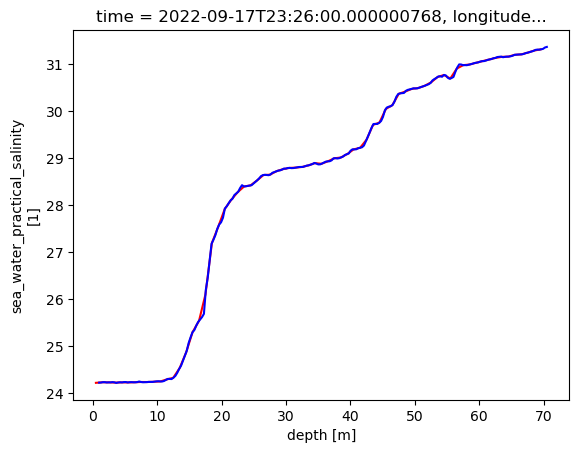

In [72]:
tmp_SA = SA[:,ji];
tmp_SA_new_Z = tmp_SA.interp(depth=new_Z_DA,kwargs={"fill_value": "extrapolate"});
tmp_SA_new_Z.plot(color='red')
tmp_SA.plot(color='blue')
print(tmp_SA_new_Z)

In [ ]:
sal_init2 = " ".join(str(np.array(sRefgood[i]))+str(',') for i in np.arange(sRefgood.size)).split()
np.array(sal_init2).reshape(1,sRefgood.size)

In [ ]:
df = pd.DataFrame(np.array(sal_init2).reshape(1,sRefgood.size))
df

In [ ]:
df.to_csv(save_data+'SalRefgood.csv', index=False, header=False)

In [ ]:
zato2 = " ".join(str(np.array(tRefgood[i]))+str(',') for i in np.arange(tRefgood.size)).split()
np.array(zato2).reshape(1,tRefgood.size)

In [ ]:
df = pd.DataFrame(np.array(zato2).reshape(1,sRefgood.size))
df

In [ ]:
df.to_csv(save_data+'TempgoodRef.csv', index=False, header=False)

In [ ]:
plt.figure()
ax = plt.subplot(121)
ax.plot(SREF[0:nSel],z_mitgcm[0:nSel],'-b')
#plt.ylim(0,100)
ax.invert_yaxis()

plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(TREF[0:nSel],z_mitgcm[0:nSel],'-r')
#plt.ylim(0,100)
ax.invert_yaxis()
plt.title('poTemp [˚C]')


In [ ]:
deltA = np.ones(z_mitgcm.size,dtype=int)*2
deltA.astype(int)

In [ ]:
TREF2 = TREF[0:nSel]
SREF2 = SREF[0:nSel]

In [ ]:
plt.figure()
ax = plt.subplot(121)
ax.plot(SREF2,z_mitgcm2,'-b')
ax.invert_yaxis()
plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(TREF2,z_mitgcm2,'-r')
ax.invert_yaxis()
plt.title('poTemp [˚C]')

In [ ]:
tRef = np.array(tRef)
#tRef

In [ ]:
sRef = np.array(sRef)
#sRef.size

In [ ]:
# creating a binary files for sRef and tRef

In [ ]:
PlaceOfSave = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/1D_ocean_ice_column/run/'

In [ ]:
# to create ==> h.astype('>f4').tofile('bathy.bin')
TREF.astype('>f4').tofile(PlaceOfSave+'TEmpRef.bin')
SREF.astype('>f4').tofile(PlaceOfSave+'SAlRef.bin')
# to read ==> h = np.fromfile('bathy.bin', '>f4').reshape(ny, nx)

In [ ]:
TREF2.size
nbjdkbfhuh = jkhnfhedv

In [ ]:
# to create ==> h.astype('>f4').tofile('bathy.bin')
##TREF2.astype('>f4').tofile('/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/ManuConfig/TEmpRef.bin')
##SREF2.astype('>f4').tofile('/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/ManuConfig/SAlRef.bin')
# to read ==> h = np.fromfile('bathy.bin', '>f4').reshape(ny, nx)

In [ ]:
# Learning how to group 
#oiuwhjnf = jbksgfjr

In [ ]:
#import MITgcmutils as mitgcm

In [ ]:
#help(mitgcm.rdmds)

In [ ]:
rept = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/SelfExpMITgcm/T*'

In [ ]:
zinga = mitgcm.rdmds(rept,[0,100,11000])
np.squeeze(zinga).shape

In [ ]:
np.squeeze(zinga)

In [ ]:
Rep_fil = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/SelfExpMITgcm/mnc_test_0001/'

In [ ]:
AA = xr.open_dataset(Rep_fil+'tave.0000000000.t001.nc')
AA

ice = xr.open_dataset(Rep_fil+'sice_tave.0000000000.t001.nc')
ice

In [ ]:
ice.si_HEFFtave.plot()

In [ ]:
Temp = AA.Ttave
Time = AA.T
depth = AA.Z

In [ ]:
Temp.shape

In [ ]:
(Temp[:,0:10]).T.plot()

In [ ]:
BB = xr.open_dataset(Rep_fil+'state.0000000000.t001.nc')
BB

In [ ]:
Temp2 = BB.Temp
Time2 = BB.T
depth2 = BB.Z

In [ ]:
(Temp2[:,0:10]).T.plot();


plt.figure()
for i in range(4):
    Temp2[:,i].plot()

In [ ]:
CC = xr.open_dataset(Rep_fil+'kpp_state.0000000000.t001.nc')
CC

In [ ]:
KppT = CC.KPPdiffKzT
KppG = CC.KPPGHAT
KppH = CC.KPPHBL

In [ ]:
KppT[:,0].plot()
KppT[:,1].plot()
KppT[:,2].plot()

In [ ]:
KppH.plot()

In [ ]:
30*60